In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models 
from torchvision.utils import make_grid
import torchvision
import os
import random
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [3]:
def build_datasets():

    transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    trainset = torchvision.datasets.ImageFolder(root='Breast_cancer_40/train', transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)
    validset = torchvision.datasets.ImageFolder(root='Breast_cancer_40/valid', transform=transform)
    validloader = torch.utils.data.DataLoader(validset, batch_size=32,
                                         shuffle=False, num_workers=2)
    testset = torchvision.datasets.ImageFolder(root='Breast_cancer_40/valid', transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

    return trainloader,validloader, testloader

classes = ('Adenosis', 'Ductal_Carcinoma', 'Fibroadenoma', 'Lobular_Carcinoma',
               'Mucinous_Carcinoma', 'Papillary_Carcinoma', 'Phyllodes_tumor', 'Tubular_adenoma')

In [4]:

trainloader,validloader, testloader= build_datasets()



In [5]:
import torch.nn as nn
import torch.nn.functional as F
# define the CNN architecture

class CNN(nn.Module):
    def __init__(self, num_classes: int = 8, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.maxpool = nn.MaxPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.maxpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

net = CNN()
net

CNN(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (maxpool): MaxPool2d(kernel_size=(6, 6), stride=(6, 6), padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_fea

In [6]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [39]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def valid(model,iterator):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [40]:
import seaborn as sn
import torch.nn as nn
import torch.nn.functional as F
import time

train_l = []
train_a = []
valid_l = []
valid_a = []

if __name__ == '__main__':

    for epoch in range(100):
        start_time = time.monotonic()
        train_loss, train_acc = train(net, trainloader, optimizer, criterion, device)
        valid_loss, valid_acc = valid(net, validloader)
        
        train_l.append(train_loss)
        train_a.append(train_acc)
        valid_l.append(valid_loss)
        valid_a.append(valid_acc)
        
        end_time = time.monotonic()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
        print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc * 100:.2f}%')
    print('Finished Training')

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network test images: %d %%' % (
            100 * correct / total))

Epoch: 01 | Epoch Time: 1m 38s
	Train Loss: 1.792 | Train Acc: 42.11%
	Valid Loss: 1.825 | Valid Acc: 43.25%
Epoch: 02 | Epoch Time: 1m 35s
	Train Loss: 1.648 | Train Acc: 44.92%
	Valid Loss: 1.760 | Valid Acc: 44.00%
Epoch: 03 | Epoch Time: 1m 35s
	Train Loss: 1.652 | Train Acc: 45.25%
	Valid Loss: 2.167 | Valid Acc: 43.25%
Epoch: 04 | Epoch Time: 1m 35s
	Train Loss: 1.652 | Train Acc: 45.39%
	Valid Loss: 1.782 | Valid Acc: 43.00%
Epoch: 05 | Epoch Time: 1m 34s
	Train Loss: 1.606 | Train Acc: 46.26%
	Valid Loss: 1.933 | Valid Acc: 43.50%
Epoch: 06 | Epoch Time: 1m 34s
	Train Loss: 1.563 | Train Acc: 49.26%
	Valid Loss: 1.747 | Valid Acc: 35.50%
Epoch: 07 | Epoch Time: 1m 35s
	Train Loss: 1.506 | Train Acc: 49.06%
	Valid Loss: 1.838 | Valid Acc: 44.25%
Epoch: 08 | Epoch Time: 1m 34s
	Train Loss: 1.560 | Train Acc: 48.93%
	Valid Loss: 1.630 | Valid Acc: 44.25%
Epoch: 09 | Epoch Time: 1m 34s
	Train Loss: 1.458 | Train Acc: 49.00%
	Valid Loss: 1.698 | Valid Acc: 43.75%
Epoch: 10 | Epoch T

In [59]:
print(valid_a)

[0.4325, 0.44, 0.4325, 0.43, 0.435, 0.355, 0.4425, 0.4425, 0.4375, 0.445, 0.47, 0.4925, 0.5375, 0.4825, 0.64, 0.6325, 0.7528571429848671, 0.7932142859697342, 0.665, 0.745, 0.810357142984867, 0.7825, 0.8, 0.765, 0.7975, 0.76, 0.8132142859697342, 0.805, 0.81, 0.8025, 0.8025, 0.8075, 0.815, 0.8075, 0.8025, 0.805357142984867, 0.805357142984867, 0.8, 0.8128571429848671, 0.805357142984867, 0.8128571429848671, 0.8075, 0.7928571429848671, 0.7975, 0.8028571429848671, 0.81, 0.810357142984867, 0.7553571429848671, 0.800357142984867, 0.805357142984867, 0.810357142984867, 0.8153571429848671, 0.7978571429848671, 0.805357142984867, 0.8153571429848671, 0.8203571429848671, 0.805357142984867, 0.8028571429848671, 0.805357142984867, 0.8078571429848671, 0.800357142984867, 0.800357142984867, 0.8078571429848671, 0.8078571429848671, 0.805357142984867, 0.8028571429848671, 0.805357142984867, 0.7978571429848671, 0.805357142984867, 0.8153571429848671, 0.8028571429848671, 0.8128571429848671, 0.810357142984867, 0.80

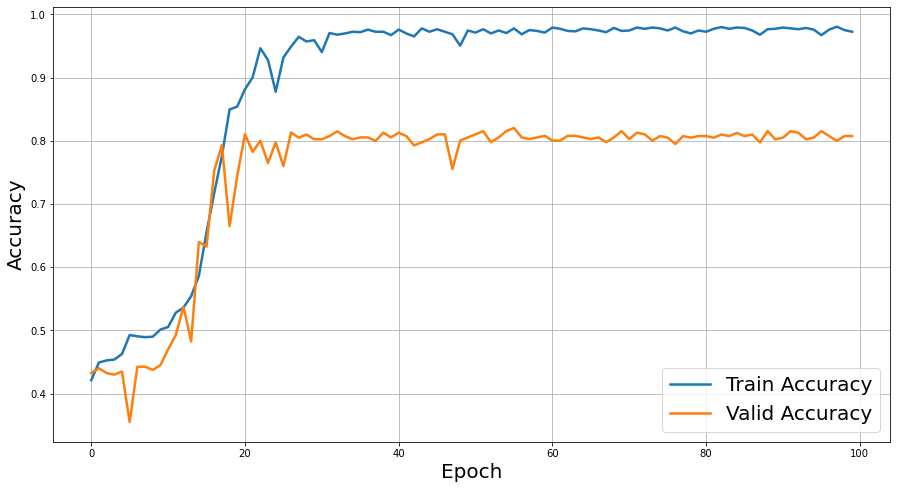

In [55]:
plt.figure(figsize=(15,8))
plt.plot(train_a,label='Train Accuracy',linewidth=2.5)
plt.plot(valid_a,label='Valid Accuracy',linewidth=2.5)
plt.xlabel('Epoch',size=20)
plt.ylabel('Accuracy',size=20)
plt.legend(fontsize = 20)
plt.grid()

In [109]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [110]:
dataiter = iter(testloader)
images, labels = dataiter.next()

In [111]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

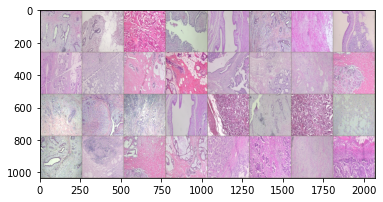

In [112]:
outputs = net(images)
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
    
    
transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

testset = torchvision.datasets.ImageFolder(root='Breast_cancer_40/test', transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=True, num_workers=2)
trainset = torchvision.datasets.ImageFolder(root='Breast_cancer_40/train', transform=transform)
train_loader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=True, num_workers=2)

import torchvision
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
inputs, classes = next(iter(train_loader))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out)

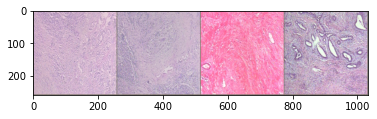

Predicted:  Phyllodes_tumor Adenosis Adenosis Adenosis


In [113]:
transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

testset = torchvision.datasets.ImageFolder(root='Breast_cancer_40/test', transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=True, num_workers=2)


dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))

_, predicted = torch.max(outputs, 1)
classes = ('Adenosis', 'Ductal_Carcinoma', 'Fibroadenoma', 'Lobular_Carcinoma',
               'Mucinous_Carcinoma', 'Papillary_Carcinoma', 'Phyllodes_tumor', 'Tubular_adenoma')

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [43]:
classes = ('Adenosis', 'Fibroadenoma', 'Phyllodes_tumor' ,'Tubular_adenoma','Ductal_Carcinoma', 'Lobular_Carcinoma',
               'Mucinous_Carcinoma', 'Papillary_Carcinoma')

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class Adenosis is: 63.6 %
Accuracy for class Fibroadenoma is: 84.6 %
Accuracy for class Phyllodes_tumor is: 61.9 %
Accuracy for class Tubular_adenoma is: 66.7 %
Accuracy for class Ductal_Carcinoma is: 93.1 %
Accuracy for class Lobular_Carcinoma is: 74.2 %
Accuracy for class Mucinous_Carcinoma is: 73.2 %
Accuracy for class Papillary_Carcinoma is: 62.1 %


In [61]:
import sklearn

def test_label_predictions(model, device, test_loader):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]

actuals, predictions = test_label_predictions(net, device, testloader)
print('Confusion matrix:')
print(sklearn.metrics.confusion_matrix(actuals, predictions))
print('F1 score: %f' % sklearn.metrics.f1_score(actuals, predictions, average='micro'))
print('Accuracy score: %f' % sklearn.metrics.accuracy_score(actuals, predictions))

Confusion matrix:
[[ 14   4   0   1   3   0   0   0]
 [  0  44   0   3   5   0   0   0]
 [  3   1  13   4   0   0   0   0]
 [  0   0   0  20  10   0   0   0]
 [  0   4   0   2 161   2   4   0]
 [  0   0   0   0   7  23   1   0]
 [  0   2   0   1   8   0  30   0]
 [  1   2   0   2   3   0   3  18]]
F1 score: 0.809524
Accuracy score: 0.809524


In [10]:
a = [[ 14  , 4  , 0 ,  1  , 3 ,  0 ,  0 ,  0],
     [  0  ,44 ,  0  , 3,   5 ,  0 ,  0 ,  0],
     [  3  , 1 , 13,   4,   0 ,  0 ,  0 ,  0],
     [  0  , 0  , 0 , 20 , 10 ,  0 ,  0 ,  0],
     [  0  , 4 ,  0  , 2 ,161 ,  2 ,  4 ,  0],
     [  0  , 0  , 0 ,  0  , 7 , 23 ,  1 ,  0],
     [  0  , 2 ,  0 ,  1  , 8 ,  0 , 30 ,  0],
     [  1  , 2  , 0  , 2  , 3 ,  0 ,  3 , 18]]

b = [[ 14/22 ,  4/22  , 0 ,  1/22  , 3/22 ,  0 ,  0 ,  0],
     [  0  ,44/53,   0 ,  3/53,   5/53,   0,   0,   0],
     [  3/21  , 1/21 , 13/21 ,  4/21 ,  0  , 0 ,  0  , 0],
     [  0  , 0,   0,  20/30 , 10/30 ,  0  , 0 ,  0],
     [  0 ,  4/173 ,  0 ,  2/173, 161/173,   2/173 ,  4/173 ,  0],
     [  0  , 0,   0 ,  0 ,  7/31,  23/31  , 1/31 ,  0],
     [  0 ,  2/41 ,  0  , 1/41 ,  8/41,   0,  30/41 ,  0],
     [  1/29  , 2/29 ,  0 ,  2/29 ,  3/29 ,  0  , 3/29  ,18/29]]

In [70]:
c = [[ 18  , 1  , 0 ,  2  , 1 ,  0 ,  0 ,  0],
     [  0  ,46 ,  2  , 2,   1 ,  2 ,  0 ,  0],
     [  0  , 1 , 18,   0,   2 ,  0 ,  0 ,  0],
     [  0  , 2  , 1 , 23 ,  4 ,  0 ,  0 ,  0],
     [  1  , 2 ,  2  , 3 ,156 ,  4 ,  5 ,  3],
     [  0  , 1  , 0 ,  0  , 3 , 27 ,  0 ,  0],   
     [  0  , 1 ,  0 ,  1  , 3 ,  0 , 35 ,  1],   
     [  1  , 1  , 0  , 2  , 0 ,  0 ,  1 , 24]]

d = [[ 18/22 ,  1/22  , 0 ,  2/22  , 1/22 ,  0 ,  0 ,  0],
     [  0  , 46/53,   2/53 ,  2/53,   1/53,   2/53,   0,   0],
     [  0  , 1/21 , 18/21 ,  0 ,  2/21  , 0 ,  0  , 0],
     [  0  , 2/30,   1/30,  23/30 , 4/30 ,  0  , 0 ,  0],
     [  1/173 ,  2/173 ,  2/173 ,  3/173, 153/173,   4/173 ,  5/173 ,  3/173],
     [  0  , 1/31,   0 ,  0 ,  3/31,  27/31  , 0 ,  0],  
     [  0 ,  1/41 ,  0  , 1/41 ,  3/41,   0,  35/41 ,  1/41],  
     [  1/29  , 1/29 ,  0 ,  2/29 ,  0 ,  0  , 1/29  ,24/29]]

<AxesSubplot:title={'center':'confusion Matrix x40 ohne Augmentation'}>

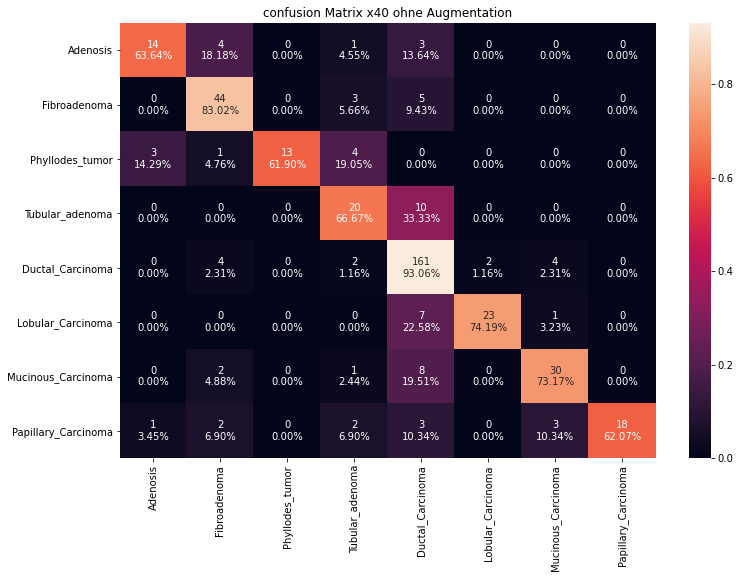

In [71]:
group_counts = ["{0:0.0f}".format(value) for value in
                np.array(a).flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     np.array(b).flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(8,8)

categories = ['Adenosis', 'Fibroadenoma', 'Phyllodes_tumor' ,'Tubular_adenoma','Ductal_Carcinoma', 'Lobular_Carcinoma',
               'Mucinous_Carcinoma', 'Papillary_Carcinoma']

plt.figure(figsize = (12,8))
plt.title('confusion Matrix x40 ohne Augmentation')
sns.heatmap(b, annot = labels, fmt='', xticklabels = categories, yticklabels = categories)


<AxesSubplot:title={'center':'confusion Matrix x40 mit Data Augmentation'}>

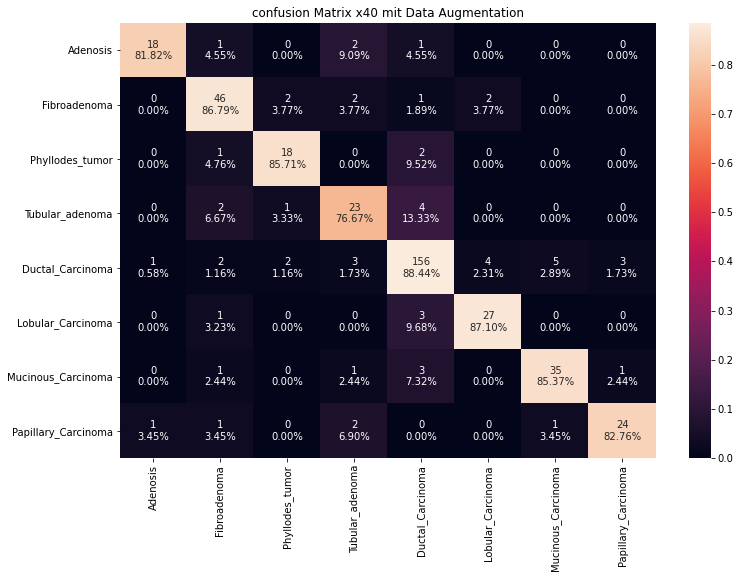

In [72]:
group_counts = ["{0:0.0f}".format(value) for value in
                np.array(c).flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     np.array(d).flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(8,8)

categories = ['Adenosis', 'Fibroadenoma', 'Phyllodes_tumor' ,'Tubular_adenoma','Ductal_Carcinoma', 'Lobular_Carcinoma',
               'Mucinous_Carcinoma', 'Papillary_Carcinoma']

plt.figure(figsize = (12,8))
plt.title('confusion Matrix x40 mit Data Augmentation')
sns.heatmap(d, annot = labels, fmt='', xticklabels = categories, yticklabels = categories)



In [2]:
def test_class_probabilities(model, device, test_loader, which_class):
    model.eval()
    actuals = []
    probabilities = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction) == which_class)
            probabilities.extend(np.exp(output[:, which_class]))
    return [i.item() for i in actuals], [i.item() for i in probabilities]

which_class = 0
actuals, class_probabilities = test_class_probabilities(net, device, testloader, which_class)

fpr, tpr, _ = sklearn.metrics.roc_curve(actuals, class_probabilities)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for label= %d ' % which_class)
plt.legend(loc="lower right")
plt.show()

NameError: name 'net' is not defined